# DeepFM 广告点击率预测


推荐系统和广告CTR预估主流模型的演化有两条主要路线。

第一条是显式建模特征交互，提升模型对交叉特征的捕获能力。(如Wide&Deep,PNN,FNN,DCN,DeepFM,AutoInt等)

第二条是加入注意力机制，提升模型的自适应能力和解释性。(如DIN,DIEN,DSIN,FiBiNET,AutoInt等)

在所有这些模型中，DeepFM属于性价比非常高的模型（结构简洁，计算高效，指标有竞争力）。

张俊林大佬 在2019年的时候甚至建议 沿着 LR->FM->DeepFM->干点别的 这样的路线去迭代推荐系统。



本范例演示使用 torchkeras.tabular.DeepFMModel 进行广告点击率预测。

有关DeepFM模型的完整理论介绍，参考如下eat_pytorch_in_20_days中的讲解教程：

https://github.com/lyhue1991/eat_pytorch_in_20_days/blob/master/7-4%2CDeepFM%E6%A8%A1%E5%9E%8B.ipynb



公众号**算法美食屋**后台回复关键词：torchkeras，获取本文notebook源码和所用criteo_small数据集下载链接。


## 一，准备数据

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

np.random.seed(42)


In [2]:
from sklearn.preprocessing import LabelEncoder

dfdata = pd.read_csv('criteo_small.zip',sep='\t',header=None)
dfdata.columns = ["label"] + ["I"+str(x) for x in range(1,14)] + [
    "C"+str(x) for x in range(14,40)]

target_col = 'label'
cat_cols = [x for x in dfdata.columns if x.startswith('C')]
num_cols = [x for x in dfdata.columns if x.startswith('I')]


In [3]:
dftrain_val,dftest_raw = train_test_split(dfdata,test_size=0.2,random_state=42)
dftrain_raw,dfval_raw = train_test_split(dftrain_val,test_size=0.2,random_state=42)


In [4]:
from torchkeras.tabular import TabularPreprocessor
from sklearn.preprocessing import OrdinalEncoder

#特征工程
pipe = TabularPreprocessor(cat_features = cat_cols, onehot_max_cat_num=3)
encoder = OrdinalEncoder()

dftrain = pipe.fit_transform(dftrain_raw.drop(target_col,axis=1))
dftrain[target_col] = encoder.fit_transform(
    dftrain_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dfval = pipe.transform(dfval_raw.drop(target_col,axis=1))
dfval[target_col] = encoder.transform(
    dfval_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dftest = pipe.transform(dftest_raw.drop(target_col,axis=1))
dftest[target_col] = encoder.transform(
    dftest_raw[target_col].values.reshape(-1,1)).astype(np.int32)



2024-09-04 12:47:03.893852: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-04 12:47:03.945771: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 12:47:04.728117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


  0%|          | 0/24 [00:00<?, ?it/s]

In [5]:
from torchkeras.tabular import TabularDataset
from torch.utils.data import Dataset,DataLoader 

def get_dataset(dfdata):
    return TabularDataset(
                data = dfdata,
                task = 'binary',
                target = [target_col],
                continuous_cols = pipe.get_numeric_features(),
                categorical_cols = pipe.get_embedding_features()
        )

def get_dataloader(ds,batch_size=512,num_workers=0,shuffle=False):
    dl = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=False,
        )
    return dl 
    
ds_train = get_dataset(dftrain)
ds_val = get_dataset(dfval)
ds_test = get_dataset(dftest)

dl_train = get_dataloader(ds_train,batch_size=2048,shuffle=True)
dl_val = get_dataloader(ds_val,batch_size=2048,shuffle=False)
dl_test = get_dataloader(ds_test,batch_size=2048,shuffle=False)



In [6]:
for batch in dl_train:
    break

In [7]:
dftrain.shape 

(640000, 45)

## 二，定义模型

In [8]:
from torchkeras.tabular.models import DeepFMConfig, DeepFMModel 

model_config = DeepFMConfig(
    task="binary",
    deep_layers = "128-64-32",
    deep_dropout = 0.1
)

config = model_config.merge_dataset_config(ds_train)

print('input_embed_dim = ', config.input_embed_dim)
print('\n categorical_cardinality = ',config.categorical_cardinality)
print('\n embedding_dims = ' , config.embedding_dims)


input_embed_dim =  32

 categorical_cardinality =  [1000, 529, 1000, 1000, 246, 15, 1000, 502, 1000, 1000, 1000, 1000, 26, 1000, 1000, 10, 1000, 1000, 1000, 16, 15, 1000, 63, 1000]

 embedding_dims =  [[1000, 50], [529, 50], [1000, 50], [1000, 50], [246, 50], [15, 8], [1000, 50], [502, 50], [1000, 50], [1000, 50], [1000, 50], [1000, 50], [26, 13], [1000, 50], [1000, 50], [10, 5], [1000, 50], [1000, 50], [1000, 50], [16, 8], [15, 8], [1000, 50], [63, 32], [1000, 50]]


In [9]:
net = DeepFMModel(config = config)

#初始化参数
net.reset_weights()
net.data_aware_initialization(dl_train)




In [10]:
output = net.forward(batch)
loss = net.compute_loss(output,batch['target'])
print(loss)

tensor(6.3892, grad_fn=<AddBackward0>)


## 三，训练模型

In [11]:
from torchkeras import KerasModel 
from torchkeras.tabular import StepRunner 
KerasModel.StepRunner = StepRunner 

import torch 
from torchkeras.metrics import AUC 

optimizer = torch.optim.AdamW(net.parameters(),lr = 1e-3)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
#                                                steps_per_epoch=len(dl_train), epochs=20)

keras_model = KerasModel(net,
                   loss_fn=None,
                   optimizer = optimizer,
                   metrics_dict = {'auc':AUC()}
                   )


Detected kernel version 5.4.186, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


<<<<<< ⚡️ cuda is used >>>>>>


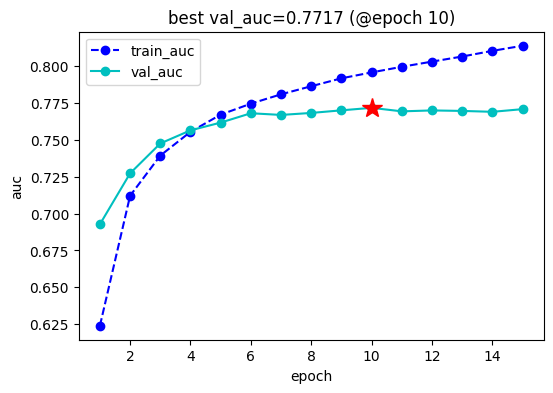

<<<<<< val_auc without improvement in 5 epoch,early stopping >>>>>> 



,epoch,train_loss,train_auc,lr,val_loss,val_auc
0,1,1.408187,0.623909,0.001,0.619509,0.692739
1,2,0.584702,0.712103,0.001,0.541251,0.727292
2,3,0.528367,0.739340,0.001,0.508937,0.747557
3,4,0.502788,0.755457,0.001,0.495135,0.756461
4,5,0.487692,0.767115,0.001,0.488027,0.761710
5,6,0.478542,0.774563,0.001,0.484223,0.768054
6,7,0.471563,0.780906,0.001,0.481900,0.766908
7,8,0.465800,0.786392,0.001,0.482296,0.768268
8,9,0.460357,0.791760,0.001,0.481996,0.770032
9,10,0.456565,0.795760,0.001,0.480180,0.771727


In [12]:
keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='checkpoint',
    epochs=30,
    patience=5,
    monitor="val_auc", 
    mode="max",
    plot = True,
    wandb = False
)

## 四，评估模型

In [13]:
keras_model.evaluate(dl_train)

100%|██████████████████████████████| 313/313 [00:54<00:00,  5.78it/s, val_auc=0.818, val_loss=0.434]


{'val_loss': 0.4341495612177986, 'val_auc': 0.817977249622345}

In [14]:
keras_model.evaluate(dl_val)

100%|█████████████████████████████████| 79/79 [00:13<00:00,  5.95it/s, val_auc=0.772, val_loss=0.48]


{'val_loss': 0.48018012695674656, 'val_auc': 0.771727442741394}

In [15]:
keras_model.evaluate(dl_test)

100%|█████████████████████████████████| 98/98 [00:17<00:00,  5.69it/s, val_auc=0.77, val_loss=0.481]


{'val_loss': 0.48122845286009264, 'val_auc': 0.7695667743682861}

## 五，使用模型

In [16]:
from tqdm import tqdm 

net,dl_test = keras_model.accelerator.prepare(net,dl_test)
net.eval()
preds = []
with torch.no_grad():
    for batch in tqdm(dl_test):
        preds.append(net.predict(batch))
    

100%|██████████| 98/98 [00:02<00:00, 47.45it/s]


In [17]:
yhat_list = [yd.sigmoid().reshape(-1).tolist() for yd in preds]
yhat = []
for yd in yhat_list:
    yhat.extend(yd)

In [18]:
dftest_raw = dftest_raw.rename(columns = {target_col: 'y'})
dftest_raw['yhat'] = yhat

In [19]:
from sklearn.metrics import roc_auc_score
roc_auc_score(dftest_raw['y'],dftest_raw['yhat'])

0.7695669193178376

## 六，保存模型

最佳模型权重已经保存在ckpt_path = 'checkpoint'位置了。

In [20]:
net.load_state_dict(torch.load('checkpoint',weights_only=True))

<All keys matched successfully>